# One-Legged Hopper

In this set, we're going to spend some time with the [one-legged hopper](http://www.ai.mit.edu/projects/leglab/robots/3D_hopper/3D_hopper.html). This system (which is discussed in great detail in [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6313238) -- you can reference that paper for some parts of this set!) enables extremely dynamic walking behavior that bounces between *stance phases* when the foot is on the ground, and *flight phases* when the foot is in the air. The system is dramatically underactuated in both phases, but as you'll see in this problem set, it can still be stabilized!

## Dynamics
The (planar) one-legged hopper consists of a body with mass $m_b$ and a foot with a mass $m_f$, with the connection between the foot and the body being a single (actuated, torque-controlled) pin joint, and the leg being springy with controllable spring constant.

<p align="center">
  <img src="./planar_hopper.png" width="350"/>
</p>

The planar one-legged hopper, diagramed above, has state

$$ \mathbb{x} = \left[ \begin{array} \\ q \\ \dot q \end{array}\right] \ \ \ q = \left[\begin{array}\\ x \\ z \\ \theta \\ \alpha \\ l\end{array}\right] $$

for floating base coordinates $x, z, \theta$, hip angle $\alpha$, and leg extension $l$ limited to $\left[-\infty, l_{max}\right]$. This joint limit is implemented with a highly damped one-sided (i.e., only active when the limit is exceeded) spring. The "springiness" in the leg is represented by a force $f_{spring} = K_l * (l_{rest} - l)$ that pushes the foot back to full extension when it is compressed. **The system has two control inputs: instantaneous control of $l_{rest}$, and direct torque control of the leg angle.**

This system is hybrid due to the joint limit and ground contact, and (usually) oscillates between two contact modes:

1) **Flight**: When the foot is not in contact with the ground and the leg is fulled extended to $l = l_{max}$ (these usually occur simultaneously, as in flight there's nothing stopping the leg from passively extending). In this mode, the whole assembly flies through the air under the influence of gravity.

2) **Stance**: When the foot is in contact with the ground, a ground reaction force (also represented with a highly damped one-sided spring) pushes the foot out of collision with the ground.

## Controlling the Hopper

As discussed in lecture, one might think about controlling this system by separating it into three separate control problems:

1) Controlling the hopping height of the body by pushing off the ground while in stance phase

2) Controlling the horizontal velocity of the body by choosing where to place the foot during the next stance phase (which requires exerting torque during flight phase to aim the leg)

3) Controlling the angular velocity of the body by applying a torque to the leg while in stance phase

In this section we'll play with a planar model of the 1D hopper. **We've supplied a controller that will take care of regulating the hopping height (using Raibert's very simple controller) by modifying the spring rest length.**


## What you have to do

Peruse the provided 1d hopper controller class in *hopper_2d.py* and understand what it is currently accomplishing. The *Hopper2dController* system implements a controller for the planar 2d hopper, and the *Simulate2dHopper* function loads in the 2d hopper from a robot description file, hooks up the controller, and runs a simulation. The controller calculates its output in *_DoCalcVectorOutput*, but dispatches its decision making to two other methods: 

- *ChooseSpringRestLength* picks the instantaneous rest length of the spring. We've written this for you, implementing something like Raibert's original hopper height controller.
- *ChooseThighTorque* picks a leg angle torque (which directly controls $\ddot \alpha$). You have to write this one!

**Fill in ChooseThighTorque with a leg angle torque controller that lateral velocity to the desired lateral velocity, and also keeps the body steady ($\theta = 0$).** Comment your code thoroughly explaining what your controller is doing -- we reserve the right to dock points for functional but seemingly arbitrary code! The code snippets below are here to help you test your system (feel free to change the initial condition, the simulation duration, the lateral velocity target, the xlim and ylim of the visualizer, etc...). As usual, a battery of tests will be used to help validate your system -- feel free to peruse (but don't modify) *test_set_4.py* to see the conditions we're testing.

### Advice:
- While you're very welcome to explore (any method that passes the tests is technically OK!), I recommend implementing one of the three controllers described in Section IV of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6313238&tag=1). In particular, the 3rd controller ("Servo Attitude") we found to be particularly effective and simple to implement. Like many "intuitive"-style controllers, it has a handful of parameters that must be estimated (e.g. the typical duration of flight and stance phases), which you are free to infer from looking at simulation runs and hard-coding.
- Gain tuning will undoubtedly be a stumbling block here. Start as simple as you can: for example, focus first on controlling lateral velocity to 0 (i.e. just maintain balance), then controlling lateral velocity to reasonable speeds, and then finally controlling the body angle to near zero. Only try to tune one number at a time!
- Friction with the ground is *not infinite*, so if you see the foot slipping, fix your foot placement or limit your leg angle torques.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


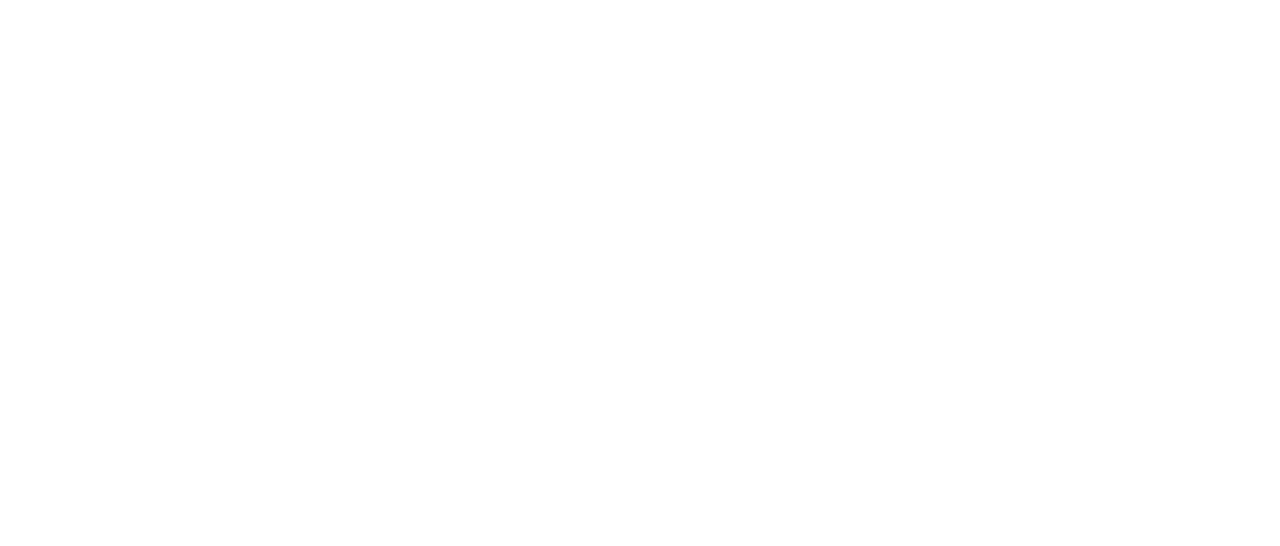

t:  0.0


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import hopper_2d
import numpy as np
import matplotlib.pyplot as plt
import math

# x0 = np.zeros(10)
# x0[1] = 1.5
# x0[4] = 0.5
# x0[5] = 0.1

lift_off_plus_state = np.zeros(10)
lift_off_plus_state[1] = 3.0 # foot just touching the ground
lift_off_plus_state[4] = 0.5 # l distance
lift_off_plus_state[0+5] = 1.5 # xd
hopper, controller, state_log, animation = hopper_2d.Simulate2dHopper(x0 = lift_off_plus_state,
                               duration=3,
                               desired_lateral_velocity = 0.0,
                               print_period = 1.0)
print('Done')

In [35]:
from IPython.display import HTML
HTML(animation.to_jshtml())

<IPython.core.display.Javascript object>


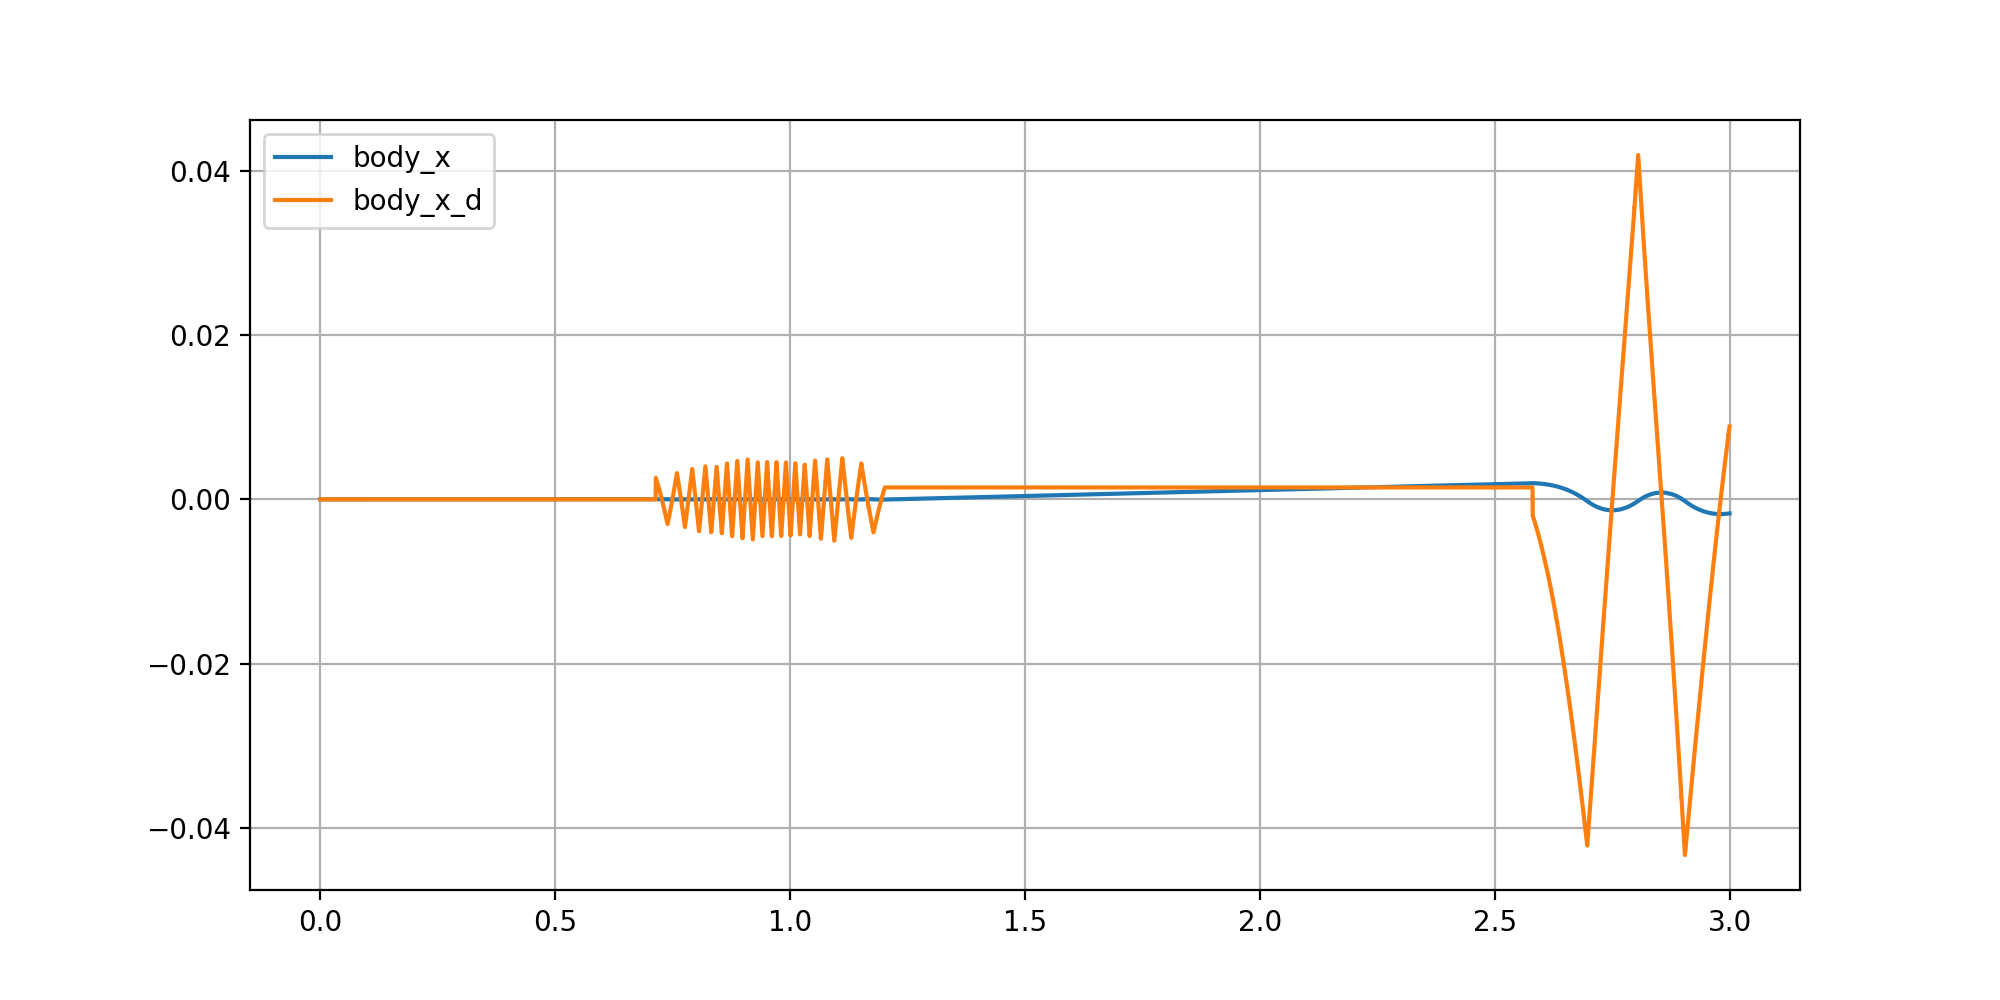

<IPython.core.display.Javascript object>


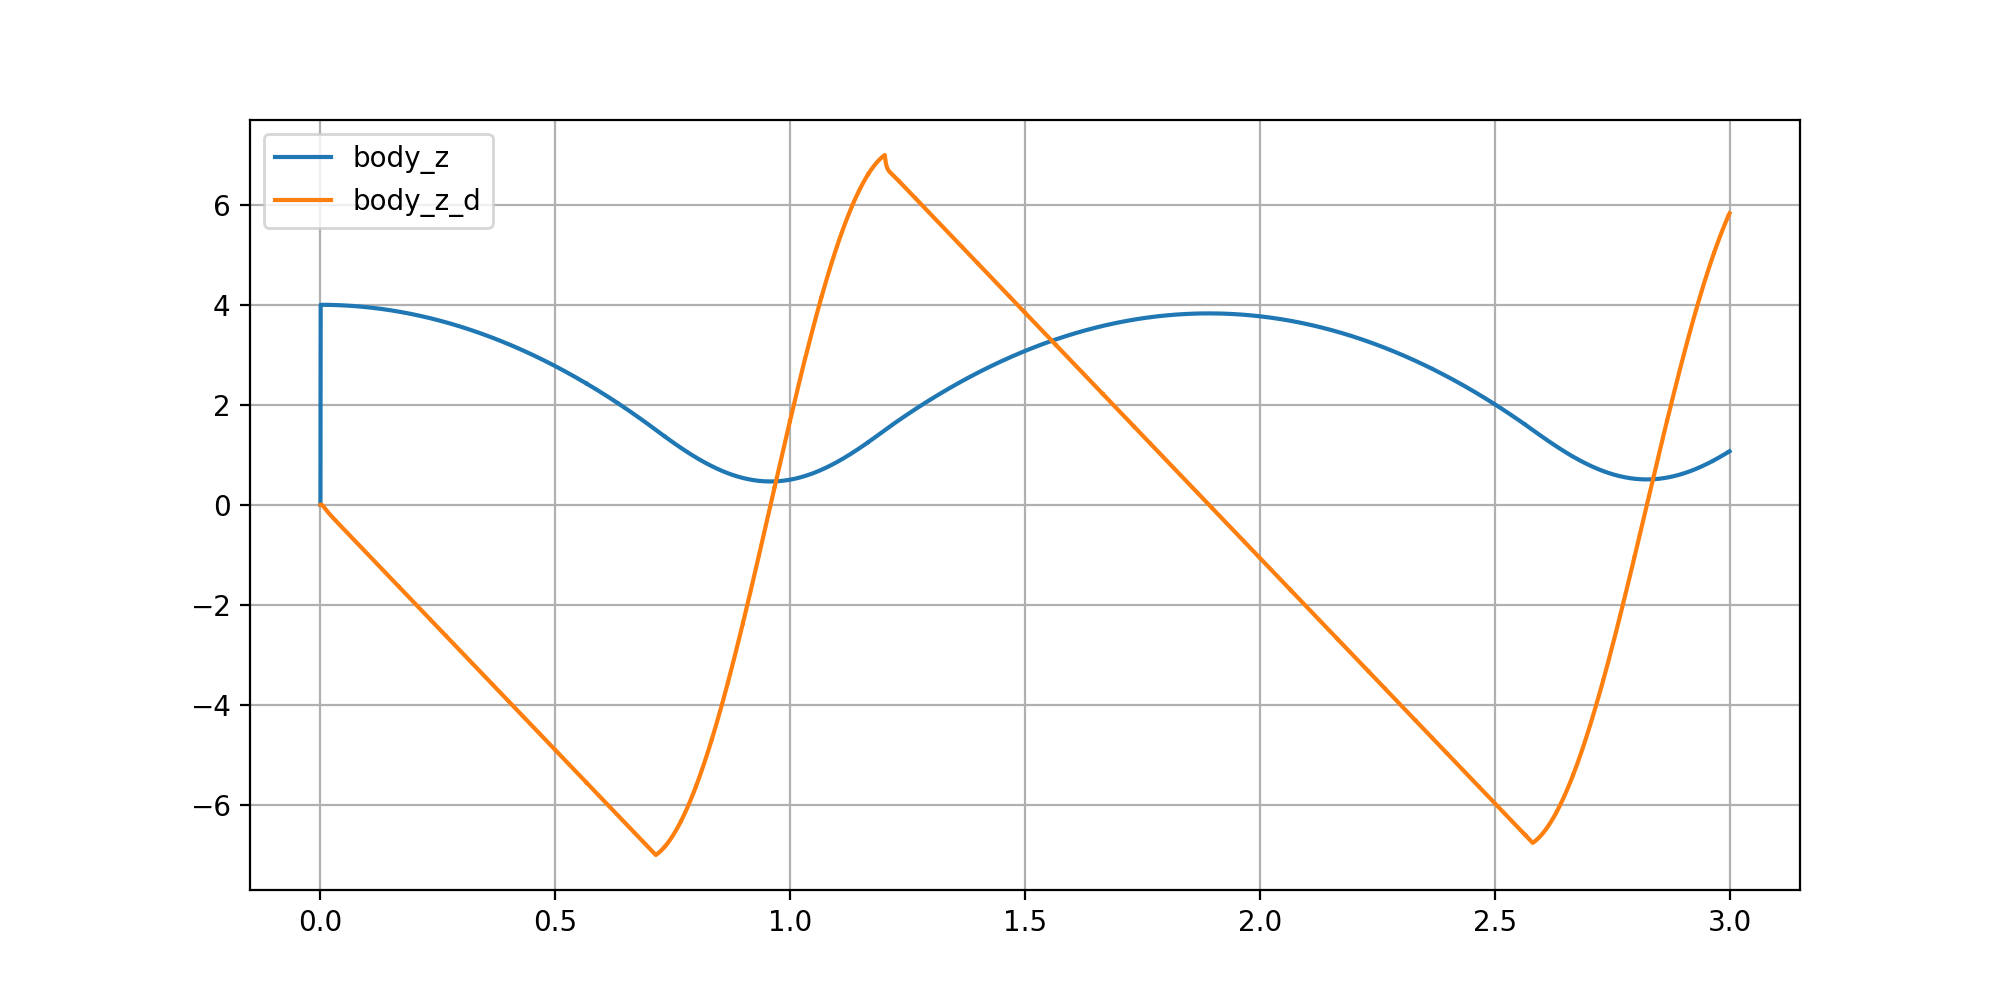

<IPython.core.display.Javascript object>


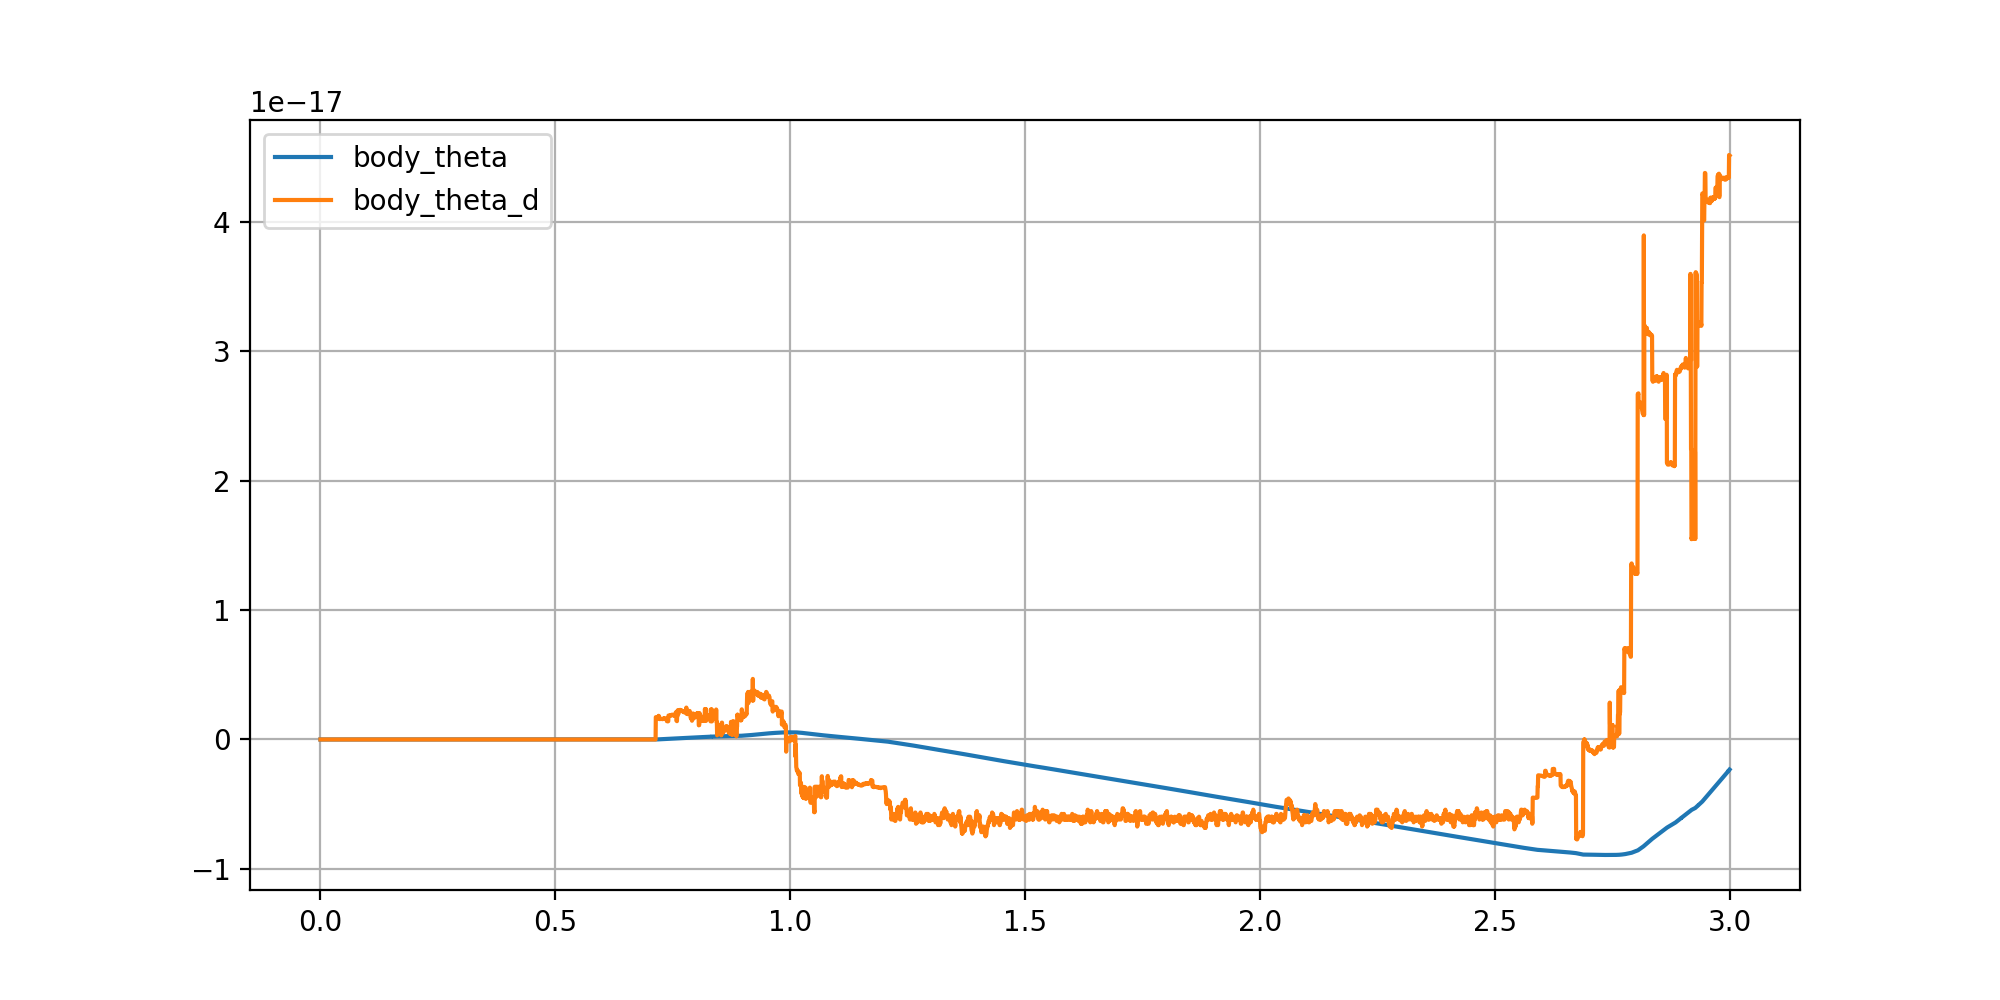

<IPython.core.display.Javascript object>


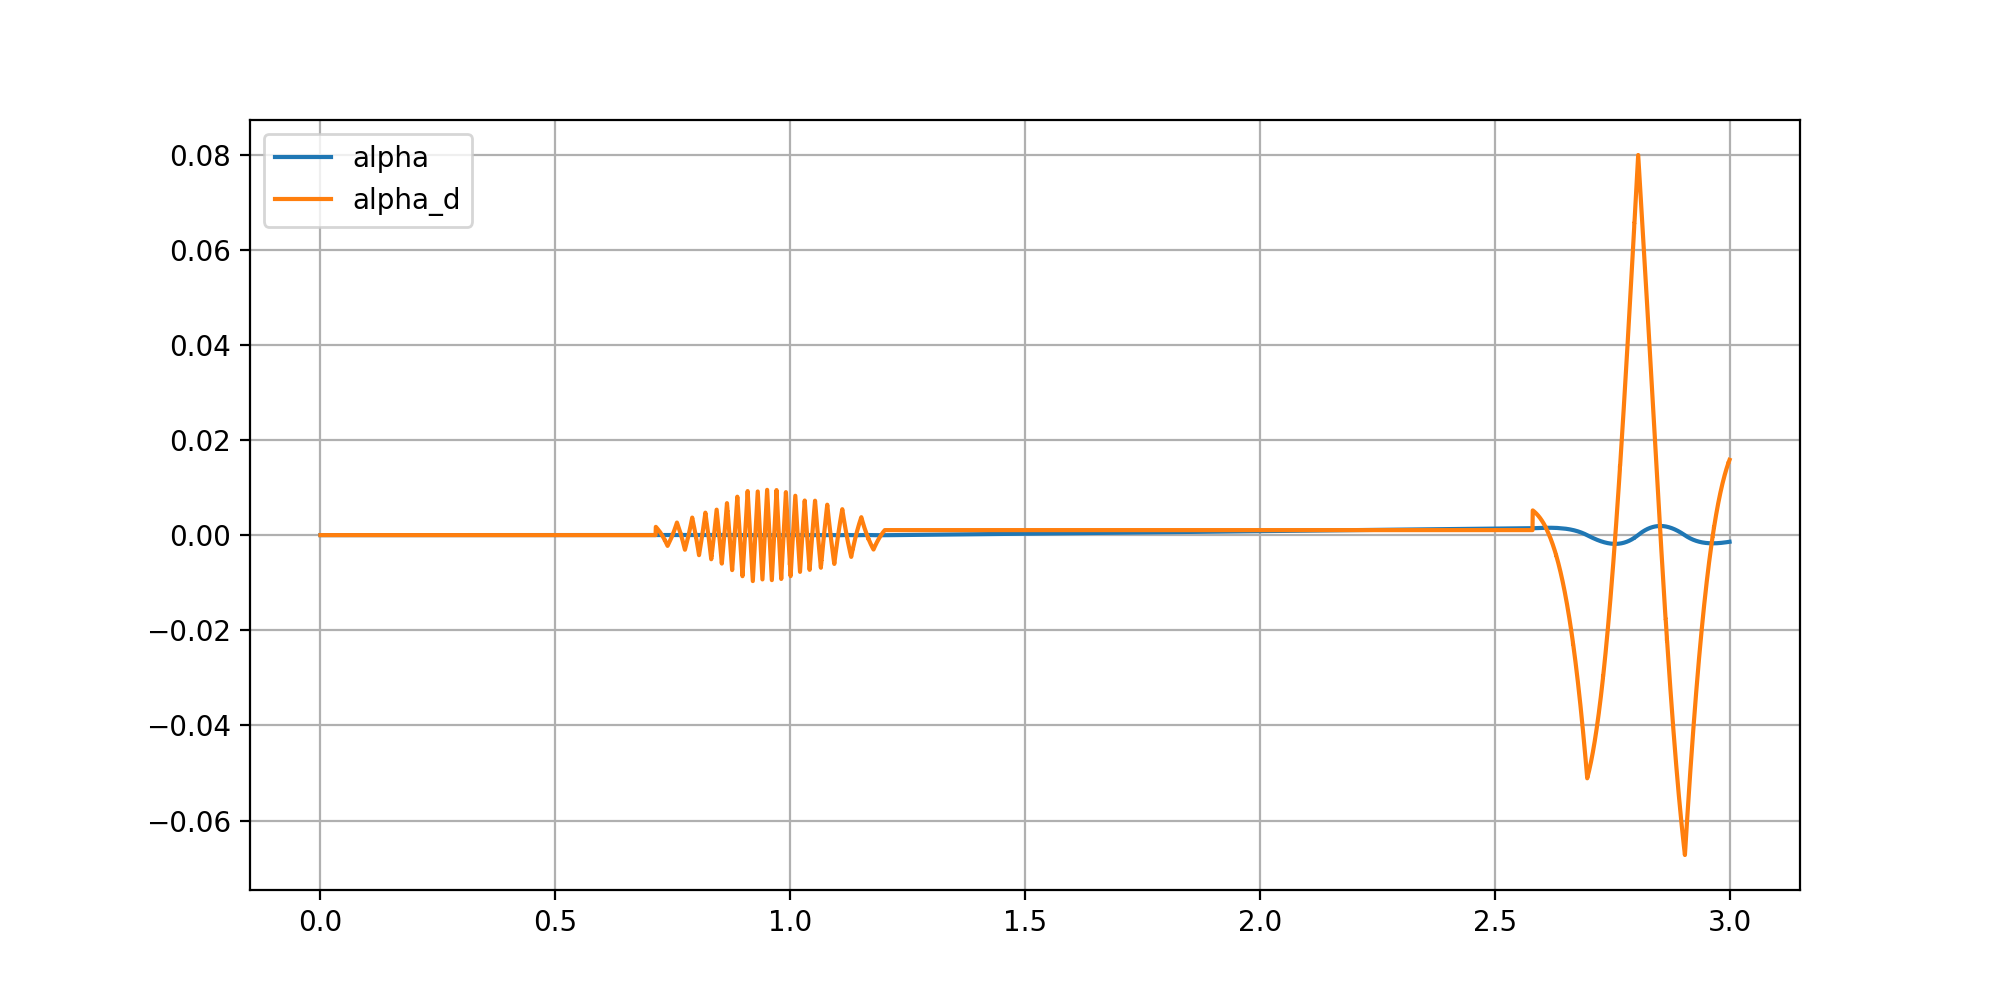

<IPython.core.display.Javascript object>


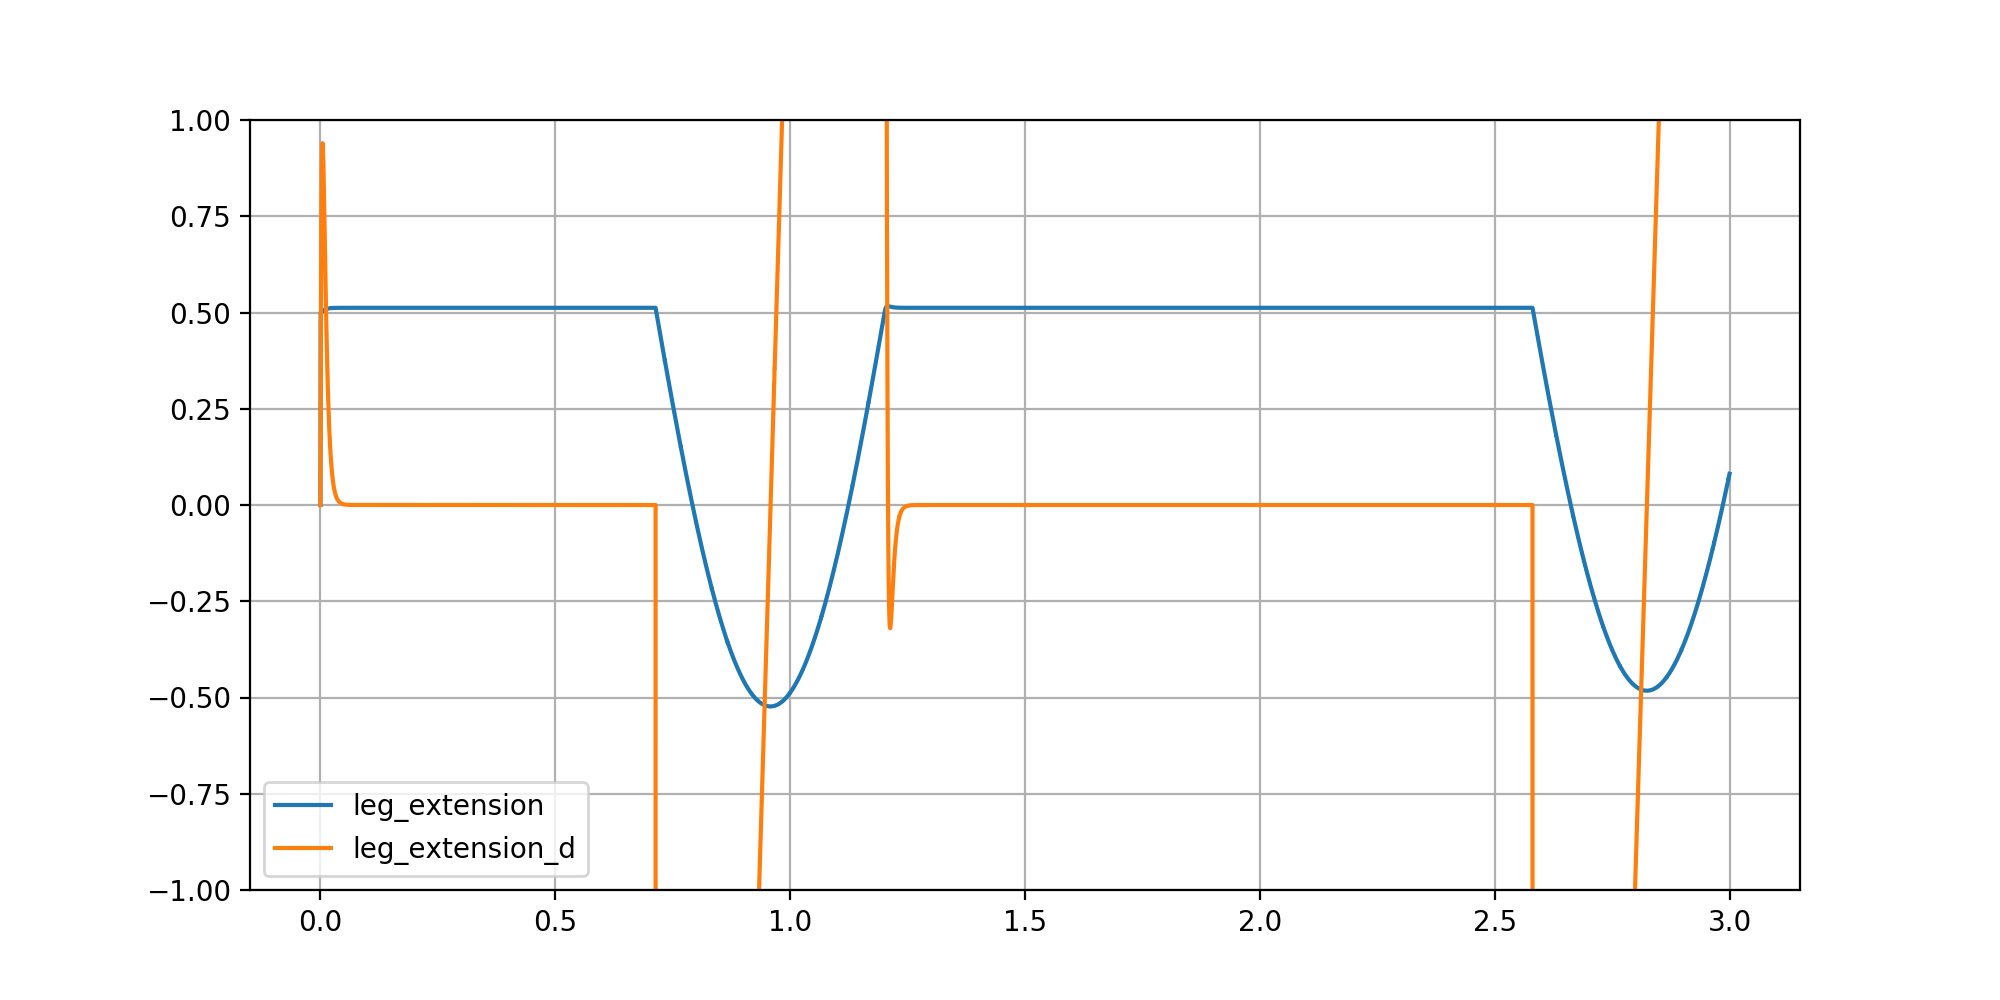

In [17]:
# Plot traces of certain states
plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[0, :])
plt.plot(state_log.sample_times(), state_log.data()[0+5, :])
plt.grid(True)
plt.legend(["body_x", "body_x_d"])

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[1, :])
plt.plot(state_log.sample_times(), state_log.data()[1+5, :])
plt.grid(True)
plt.legend(["body_z", "body_z_d"])

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[2, :])
plt.plot(state_log.sample_times(), state_log.data()[2+5, :])
plt.legend(["body_theta", "body_theta_d"])
plt.grid(True)

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[3, :])
plt.plot(state_log.sample_times(), state_log.data()[3+5, :])
plt.legend(["alpha", "alpha_d"])
plt.grid(True)

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[4, :])
plt.plot(state_log.sample_times(), state_log.data()[4+5, :])
plt.legend(["leg_extension", "leg_extension_d"])
plt.ylim([-1.0, 1.0])
plt.grid(True)
plt.show()
